In [1]:
# # List all directories and files in the current working directory
# for root, dirs, files in os.walk('.'):
#     print("Root directory:", root)
#     print("Subdirectories:", dirs)
#     print("Files:", files)
#     break  # Stop after the first level to avoid printing too much

In [2]:
import os
os.chdir("../")    #commment after first run


In [3]:
#imports
import dask.distributed
import pystac_client
import planetary_computer
import stackstac 
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import geopandas as gpd
from src.utils import gen_chips
from rasterio.warp import Resampling


In [4]:
print(os.getcwd())
#should be /home/benchuser/code

/home/benchuser/code


In [5]:
#os.chdir("/home/benchuser/code")

In [6]:
#config setup
import yaml
with open("notebooks/config.yml", "r") as file:
    config = yaml.safe_load(file)
print(config)  # Check the structure of the dictionary


{'sentinel_2': {'collection': 'sentinel-2-l2a', 'time_ranges': ['2023-01-01/2023-03-31', '2023-04-01/2023-06-30', '2023-07-01/2023-09-30', '2023-10-01/2023-12-31'], 'cloud_cover': 1, 'bands': ['B02', 'B03', 'B04', 'B08', 'B11', 'B12'], 'resolution': 10}, 'land_cover': {'collection': 'io-lulc-annual-v02', 'year': '2023-01-02/2023-12-31'}, 'chips': {'sample_size': 100, 'chip_size': 224}, 'output': {'directory': 'notebooks/test_output_dump', 'naming_convention': 's2_{season}_{index:05}.tif'}, 'metadata': {'file': 'metadata.csv'}}


In [7]:
# Sentinel-2 settings
s2_collection = config["sentinel_2"]["collection"]
s2_date_ranges = config["sentinel_2"]["time_ranges"]
s2_bands = config["sentinel_2"]["bands"]
s2_resolution = config["sentinel_2"]["resolution"]
cloud_cover_threshold = config["sentinel_2"]["cloud_cover"]  # Max allowed cloud cover

# Land Cover settings
lc_collection = config["land_cover"]["collection"]
lc_year = config["land_cover"]["year"]  # Year of LC dataset

# Chip settings
sample_size = config["chips"]["sample_size"]  # Grid size for homogeneity check
chip_size = config["chips"]["chip_size"]  # Output chip size

# Output settings
output_dir = config["output"]["directory"]
chip_naming_convention = config["output"]["naming_convention"]

# Metadata settings
metadata_file = config["metadata"]["file"]

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define seasons for indexing
seasons = ["JFM", "AMJ", "JAS", "OND"]

aoi_gdf = gpd.read_file("data/urbans.geojson") # or "data/aois.geojson"


In [8]:
#dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [9]:
#print(f"AOI Bounding Box: {aoi['geometry'].bounds}")

In [10]:
# for index, aoi in aoi_gdf.iterrows():
#     print(f"\nProcessing AOI at index {index}")
    
#     # Print the full 'aoi' object to see what it contains
#     print(f"AOI object: {aoi}")
    
#     # Print the type of the object to confirm it's a Series
#     print(f"Type of AOI: {type(aoi)}")
    
#     # Print the shape (it should be a 1D structure)
#     print(f"Shape of AOI: {aoi.shape}")
    
#     # Print the index to understand the structure of the Series (should only have 'geometry')
#     print(f"AOI Index: {aoi.index}")
    
#     # The 'aoi' Series contains a 'geometry' column, so access it directly
#     print(f"AOI Geometry: {aoi['geometry']}")
    
#     # If you are specifically interested in the geometry, print its bounds
#     print(f"AOI Geometry Bounds: {aoi['geometry'].bounds}")


In [11]:
def search_s2_scenes(aoi, date_range):
    """
    Searches for Sentinel-2 scenes within the AOI and date range.
    Adds debugging info to identify missing data issues.
    """
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    s2_search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=aoi['geometry'].bounds, 
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": 1}},
        sortby=["+properties.eo:cloud_cover"],
        max_items=10,
    )
    items = s2_search.item_collection()
    return list(items)  # Convert ItemCollection to a list of Items

def search_lc_scene(bbox, lc_date_range):
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    lc_search = catalog.search(
        collections=["io-lulc-annual-v02"],
        bbox=bbox,
        datetime=lc_date_range,
    )
    items = lc_search.item_collection()
    return list(items)  # Convert ItemCollection to a list of Items

def stack_s2_data(s2_items, s2_bands):
    print("\nChecking available assets in Sentinel-2 items...")
    valid_bands = [band for band in s2_bands if all(band in item.assets for item in s2_items)]
    try:
        s2_stack = stackstac.stack(
            s2_items,
            assets=valid_bands,
            epsg=s2_items[0].properties["proj:epsg"],
            resolution=10,
            fill_value=np.nan,
            dtype="float32"  # Ensure time dimension is preserved
        )
        print(f"Stacked Sentinel-2 bands: {list(s2_stack.coords['band'].values)}")
        print(f"Number of time steps: {len(s2_stack.time)}")
        return s2_stack
    except Exception as e:
        print(f"Error stacking Sentinel-2 data: {e}")
        return None
        
def stack_lc_data(lc_items, s2_epsg):
    if not lc_items:
        print("No Land Cover data found.")
        return None
    try:
        print("Stacking Land Cover images...")
        stacked_data = stackstac.stack(
            lc_items,
            dtype=np.ubyte,
            fill_value=255,
            sortby_date=False,
            epsg=s2_epsg,
            resolution=10,
            bounds_latlon=s2_items[0].bbox,
        ).squeeze()
        stacked_data = stacked_data.chunk(chunks={"x": sample_size, "y": sample_size})
        print("Stacked LC data shape:", stacked_data.shape)
        #print(f"Chunk sizes: {stacked_data.chunks}")   # Uncomment for big chunk size 
        return stacked_data
    except Exception as e:
        print(f"Error stacking Land Cover data: {e}")
        return None

def has_missing_values(array):
    """Check if the given array contains NaN values and print only when necessary."""
    has_nan = array.isnull().any().compute()
    if has_nan:
        print("Warning: Missing values detected in the chip!")
    return has_nan

def process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict, sample_size):
    print(f"Processing chips for AOI at {aoi.geometry.bounds}")
    print(f"Number of time steps in s2_stack: {len(s2_stack.time)}")

    def unique_class(window, axis=None, **kwargs):
        return np.all(window == window[0, 0], axis=axis)

    new_x = (lc_stack.shape[0] // sample_size) * sample_size
    new_y = (lc_stack.shape[1] // sample_size) * sample_size

    lc_stack_trimmed = lc_stack.isel(
        x=slice(0, new_x),
        y=slice(0, new_y)
    ).assign_coords(
        x=lc_stack.coords['x'].isel(x=slice(0, new_x)),
        y=lc_stack.coords['y'].isel(y=slice(0, new_y))
    )

    lc_uniqueness = lc_stack_trimmed.coarsen(x=sample_size, y=sample_size, boundary="trim").reduce(unique_class)

    for t in range(len(s2_stack.time)):
        acquisition_date = str(s2_stack.time[t].values)
        chip_count = 0
        print(f"Time step {t}, acquisition date: {acquisition_date}")

        for i in range(0, lc_stack_trimmed.shape[0] - sample_size + 1, sample_size):
            if chip_count >= 2:
                break
            for j in range(0, lc_stack_trimmed.shape[1] - sample_size + 1, sample_size):
                if chip_count >= 2:
                    print(f"Reached 2 chips for time period {acquisition_date}. Moving to next time period.")
                    break

                if not lc_uniqueness.isel(x=i // sample_size, y=j // sample_size):
                    continue

                s2_chip = s2_stack.isel(time=t, x=slice(i, i + sample_size), y=slice(j, j + sample_size))
                lc_chip = lc_stack_trimmed.isel(x=slice(i, i + sample_size), y=slice(j, j + sample_size))

                print(f"Checking chip at ({i}, {j}), time step {t}")
                if s2_chip.isnull().all() or lc_chip.isnull().all():
                    print(f"Skipping chip at ({i}, {j}) for time {acquisition_date}: Empty dataset (NoDataInBounds)")
                    continue

                # Derive chip ID from the location (i,j)
                chip_id = f"{i:05}_{j:05}"
                # Build file names using the chip ID and the acquisition date
                s2_chip_name = f"s2_{chip_id}_{acquisition_date}.tif"
                lc_chip_name = f"lc_{chip_id}_{acquisition_date}.tif"

                chip_metadata = {
                    "aoi_bounds": aoi.geometry.bounds,
                    "date": acquisition_date,
                    "coords": (i, j),
                    "chip_id": chip_id
                }
                chip_dict[(i, j, acquisition_date)] = (s2_chip, lc_chip, chip_metadata)

                print(f"Saving chip {s2_chip_name} to {output_dir}")
                lc_chip.rio.to_raster(os.path.join(output_dir, lc_chip_name))
                s2_chip.squeeze().drop_vars(
                    [dim for dim in s2_chip.dims if dim not in ['band', 'x', 'y']], errors="ignore"
                ).rio.to_raster(os.path.join(output_dir, s2_chip_name))
                print(f"Saved chip {s2_chip_name}")

                global_index += 1
                chip_count += 1

                if chip_count >= 8:
                    print(f"Reached 8 chips for time period {acquisition_date}. Moving to next time period.")
                    break

    print("Finished processing chips.")
    return global_index

def plot_chips(chip_dict, chip_indices):
    import matplotlib.pyplot as plt

    selected_chips = [chip_dict[idx] for idx in chip_indices if idx in chip_dict]

    if not selected_chips:
        print("No chips selected for plotting.")
        return

    num_chips = len(selected_chips)
    num_rows = (num_chips + 3) // 4  # Calculate the number of rows for 4 chips per row

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 6 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for idx, (s2_chip, lc_chip, metadata) in enumerate(selected_chips):
        if s2_chip is None or lc_chip is None:
            print(f"Skipping chip {chip_indices[idx]}: Missing data.")
            continue

        if 'time' in s2_chip.dims:
            rgb_image = s2_chip.isel(time=0).sel(band=["B04", "B03", "B02"]).transpose("y", "x", "band").compute()
        else:
            rgb_image = s2_chip.sel(band=["B04", "B03", "B02"]).transpose("y", "x", "band").compute()

        axes[idx].imshow(rgb_image.clip(0, 3000) / 3000)
        axes[idx].set_title(f"Chip {idx+1}\nDate: {metadata['date']}\nCoords: {metadata['coords']}")
        axes[idx].axis("off")

    for ax in axes[num_chips:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

global_index = 0
chip_dict = {}

for index, aoi in aoi_gdf.iterrows():
    print(f"\nProcessing AOI at index {index}")
    
    # Get the bounding box from the geometry of the AOI
    aoi_bounds = aoi['geometry'].bounds
    print(f"AOI Geometry Bounds: {aoi_bounds}")  # Print the bounding box for the AOI

    for date_range in s2_date_ranges:
        print(f"Querying for date range: {date_range}")
        
        # Search Sentinel-2 scenes for the AOI's bounding box
        s2_items = search_s2_scenes(aoi, date_range)
        if not s2_items:
            print(f"No Sentinel-2 scenes found for AOI {aoi_bounds} and date range {date_range}")
            continue
        
        expected_bands = ["B02", "B03", "B04", "B08", "B11", "B12"]
        s2_stack = stack_s2_data(s2_items, expected_bands)
        if s2_stack is None:
            print(f"Failed to stack Sentinel-2 bands for AOI {aoi_bounds} and date range {date_range}")
            continue

        # Search Land Cover data for the AOI's bounding box
        lc_items = search_lc_scene(aoi_bounds, lc_year)
        if not lc_items:
            print(f"No Land Cover data found for AOI {aoi_bounds} and date range {date_range}")
            continue
        
        lc_stack = stack_lc_data(lc_items, s2_stack.rio.crs.to_epsg())
        if lc_stack is None:
            print(f"Failed to stack Land Cover data for AOI {aoi_bounds} and date range {date_range}")
            continue
        print(f"Land Cover stack shape: {lc_stack.shape}")

        # Check the bounding box of the Land Cover data
        print(f"Land Cover Bounding Box: {lc_stack.rio.bounds()}")  # Debug print of Land Cover bounding box

        # Reproject and clip the LC stack so that its grid aligns with the Sentinel-2 data.
        # This is an example attempt (and failure) at fixing the AOI issue
        from rasterio.warp import Resampling
        lc_stack = lc_stack.rio.reproject_match(s2_stack, resampling=Resampling.nearest)
        s2_bounds = s2_stack.rio.bounds()
        lc_stack = lc_stack.rio.clip_box(*s2_bounds)
    

        # Process chips after confirming the data is available
        global_index = process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict, sample_size)
    print("stopping after 1st AOI")
    break



Processing AOI at index 0
AOI Geometry Bounds: (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
Querying for date range: 2023-01-01/2023-03-31

Checking available assets in Sentinel-2 items...
Stacked Sentinel-2 bands: ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
Number of time steps: 3


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacking Land Cover images...


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacked LC data shape: (11272, 11273)
Land Cover stack shape: (11272, 11273)
Land Cover Bounding Box: (297975.0, 3288795.0, 410705.0, 3401515.0)
Processing chips for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
Number of time steps in s2_stack: 3
Time step 0, acquisition date: 2023-01-18T08:31:59.024000000
Checking chip at (0, 200), time step 0
Saving chip s2_00000_00200_2023-01-18T08:31:59.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_00200_2023-01-18T08:31:59.024000000.tif
Checking chip at (0, 5500), time step 0
Saving chip s2_00000_05500_2023-01-18T08:31:59.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_05500_2023-01-18T08:31:59.024000000.tif
Reached 2 chips for time period 2023-01-18T08:31:59.024000000. Moving to next time period.
Time step 1, acquisition date: 2023-03-04T08:28:31.024000000
Checking chip at (0, 200), time step 1
Saving chip s2_00000_00200_2023-03-04T08:28:31.024000000.tif to notebooks/test_

/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacking Land Cover images...
Stacked LC data shape: (11272, 11273)
Land Cover stack shape: (11272, 11273)
Land Cover Bounding Box: (297975.0, 3288795.0, 410705.0, 3401515.0)


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Processing chips for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
Number of time steps in s2_stack: 10
Time step 0, acquisition date: 2023-04-03T08:26:01.024000000
Checking chip at (0, 200), time step 0
Saving chip s2_00000_00200_2023-04-03T08:26:01.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_00200_2023-04-03T08:26:01.024000000.tif
Checking chip at (0, 5500), time step 0
Saving chip s2_00000_05500_2023-04-03T08:26:01.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_05500_2023-04-03T08:26:01.024000000.tif
Reached 2 chips for time period 2023-04-03T08:26:01.024000000. Moving to next time period.
Time step 1, acquisition date: 2023-04-18T08:26:09.024000000
Checking chip at (0, 200), time step 1
Saving chip s2_00000_00200_2023-04-18T08:26:09.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_00200_2023-04-18T08:26:09.024000000.tif
Checking chip at (0, 5500), time step 1
Saving chip s2_00000_05500_2023-

/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacking Land Cover images...


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacked LC data shape: (11272, 11273)
Land Cover stack shape: (11272, 11273)
Land Cover Bounding Box: (297975.0, 3288795.0, 410705.0, 3401515.0)
Processing chips for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
Number of time steps in s2_stack: 10
Time step 0, acquisition date: 2023-07-17T08:26:09.024000000
Checking chip at (0, 200), time step 0
Saving chip s2_00000_00200_2023-07-17T08:26:09.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_00200_2023-07-17T08:26:09.024000000.tif
Checking chip at (0, 5500), time step 0
Saving chip s2_00000_05500_2023-07-17T08:26:09.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_05500_2023-07-17T08:26:09.024000000.tif
Reached 2 chips for time period 2023-07-17T08:26:09.024000000. Moving to next time period.
Time step 1, acquisition date: 2023-07-22T08:26:11.024000000
Checking chip at (0, 200), time step 1
Saving chip s2_00000_00200_2023-07-22T08:26:11.024000000.tif to notebooks/test

/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacking Land Cover images...


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacked LC data shape: (11272, 11273)
Land Cover stack shape: (11272, 11273)
Land Cover Bounding Box: (297975.0, 3288795.0, 410705.0, 3401515.0)
Processing chips for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
Number of time steps in s2_stack: 5
Time step 0, acquisition date: 2023-10-20T08:29:41.024000000
Checking chip at (0, 200), time step 0
Saving chip s2_00000_00200_2023-10-20T08:29:41.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_00200_2023-10-20T08:29:41.024000000.tif
Checking chip at (0, 5500), time step 0
Saving chip s2_00000_05500_2023-10-20T08:29:41.024000000.tif to notebooks/test_output_dump
Saved chip s2_00000_05500_2023-10-20T08:29:41.024000000.tif
Reached 2 chips for time period 2023-10-20T08:29:41.024000000. Moving to next time period.
Time step 1, acquisition date: 2023-10-25T08:29:29.024000000
Checking chip at (0, 200), time step 1
Saving chip s2_00000_00200_2023-10-25T08:29:29.024000000.tif to notebooks/test_

In [12]:
# debugging processing loop
# global_index = 0
# chip_dict = {}

# for index, aoi in aoi_gdf.iterrows():
#     print(f"\nProcessing AOI at index {index}")
    
#     # Get the bounding box from the geometry of the AOI
#     aoi_bounds = aoi['geometry'].bounds
#     print(f"AOI Geometry Bounds: {aoi_bounds}")  # Print the bounding box for the AOI

#     # Get the CRS of the entire GeoDataFrame (not the individual geometry)
#     aoi_crs = aoi_gdf.crs
#     print(f"AOI CRS: {aoi_crs}")
    
#     for date_range in s2_date_ranges:
#         print(f"Querying for date range: {date_range}")
        
#         # Search Sentinel-2 scenes for the AOI's bounding box
#         s2_items = search_s2_scenes(aoi, date_range)
#         print(f"Found {len(s2_items)} Sentinel-2 scenes for AOI {aoi_bounds} and date range {date_range}")
        
#         if not s2_items:
#             print(f"No Sentinel-2 scenes found for AOI {aoi_bounds} and date range {date_range}")
#             continue
        
#         expected_bands = ["B02", "B03", "B04", "B08", "B11", "B12"]
#         s2_stack = stack_s2_data(s2_items, expected_bands)
        
#         if s2_stack is None:
#             print(f"Failed to stack Sentinel-2 bands for AOI {aoi_bounds} and date range {date_range}")
#             continue

#         # Search Land Cover data for the AOI's bounding box
#         lc_items = search_lc_scene(aoi_bounds, lc_year)
#         print(f"Found {len(lc_items)} Land Cover scenes for AOI {aoi_bounds} and date range {date_range}")
        
#         if not lc_items:
#             print(f"No Land Cover data found for AOI {aoi_bounds} and date range {date_range}")
#             continue
        
#         lc_stack = stack_lc_data(lc_items, s2_stack.rio.crs.to_epsg())
#         if lc_stack is None:
#             print(f"Failed to stack Land Cover data for AOI {aoi_bounds} and date range {date_range}")
#             continue
#         print(f"Land Cover stack shape: {lc_stack.shape}")

#         # Check the bounding box of the Land Cover data
#         print(f"Land Cover Bounding Box: {lc_stack.rio.bounds()}")  # Debug print of Land Cover bounding box

#         # Commenting out chip processing for debugging
#         # global_index = process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict, sample_size)

#     # After each AOI is processed, we continue to the next one automatically (no `break` statement)
#     print(f"Finished processing AOI at index {index}")


In [13]:
print(chip_dict.keys())

dict_keys([(0, 200, '2023-01-18T08:31:59.024000000'), (0, 5500, '2023-01-18T08:31:59.024000000'), (0, 200, '2023-03-04T08:28:31.024000000'), (0, 5500, '2023-03-04T08:28:31.024000000'), (0, 200, '2023-04-03T08:26:01.024000000'), (0, 5500, '2023-04-03T08:26:01.024000000'), (0, 200, '2023-04-18T08:26:09.024000000'), (0, 5500, '2023-04-18T08:26:09.024000000'), (0, 200, '2023-05-03T08:26:01.024000000'), (0, 5500, '2023-05-03T08:26:01.024000000'), (0, 200, '2023-05-23T08:26:01.024000000'), (0, 5500, '2023-05-23T08:26:01.024000000'), (0, 200, '2023-06-02T08:26:01.024000000'), (0, 5500, '2023-06-02T08:26:01.024000000'), (0, 200, '2023-06-12T08:26:01.024000000'), (0, 5500, '2023-06-12T08:26:01.024000000'), (0, 200, '2023-06-17T08:26:09.024000000'), (0, 5500, '2023-06-17T08:26:09.024000000'), (0, 200, '2023-06-22T08:26:01.024000000'), (0, 5500, '2023-06-22T08:26:01.024000000'), (0, 200, '2023-06-27T08:26:09.024000000'), (0, 5500, '2023-06-27T08:26:09.024000000'), (0, 200, '2023-07-17T08:26:09.02

In [14]:
#print(chip_dict)

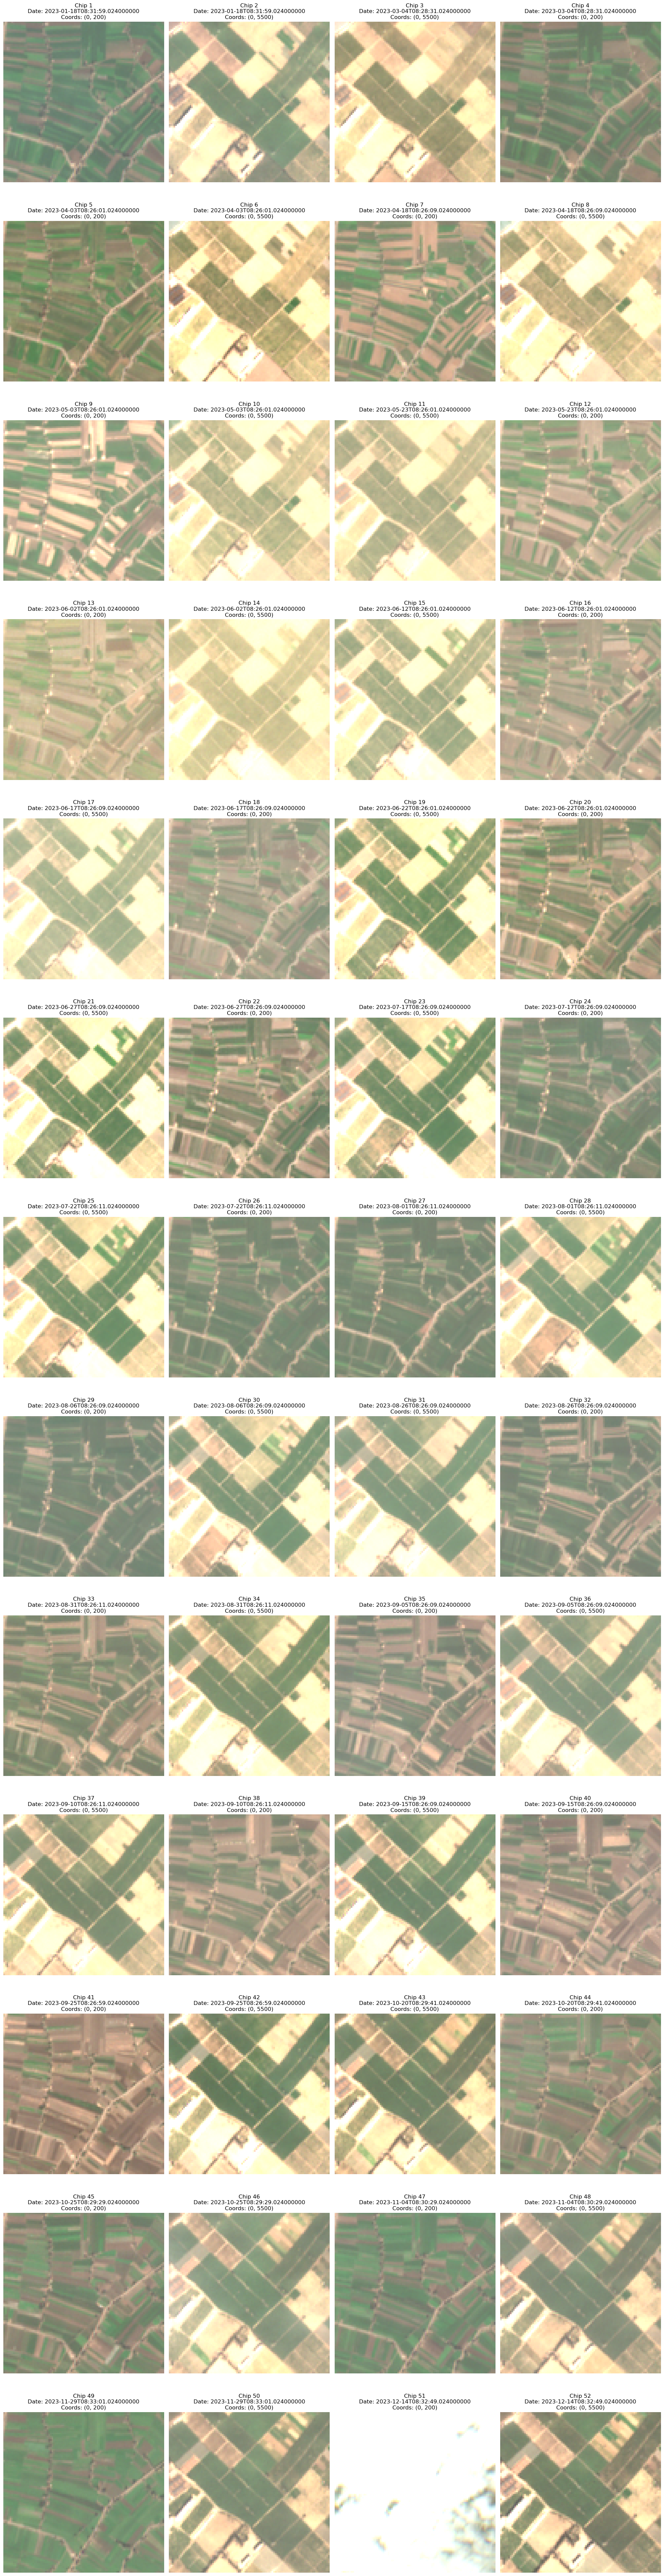

In [15]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# List of valid chip indices in chip_dict (keys are tuples of (i, j, acquisition_date))
valid_chip_indices = list(chip_dict.keys())

# Group keys by acquisition date
acquisition_groups = defaultdict(list)

# Populate the acquisition_groups dictionary with keys grouped by acquisition_date
for key in valid_chip_indices:
    acquisition_date = key[2]  # acquisition_date is the third element in the key tuple
    acquisition_groups[acquisition_date].append(key)

# Select two random chips from each acquisition date group
selected_keys = []
for acquisition_date, keys in acquisition_groups.items():
    random_keys = random.sample(keys, 2)  # Select 2 random keys from this group
    selected_keys.extend(random_keys)

# Check if we selected any chips
if not selected_keys:
    print("No chips selected for plotting.")
else:
    # Map the selected keys to actual data in chip_dict
    selected_chips = [chip_dict[key] for key in selected_keys]

    # Plot the selected chips
    plot_chips(chip_dict, selected_keys)


In [16]:
#print(s2_stack)

In [17]:
#print(s2_stack.isel(band=0))

In [18]:
#print(chip_dict)